In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv('./data/train/train.csv')

In [3]:
train.tail()

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET
52555,1094,21,30,0,0,2.4,70.70,-4,0.0
52556,1094,22,0,0,0,2.4,66.79,-4,0.0
52557,1094,22,30,0,0,2.2,66.78,-4,0.0
52558,1094,23,0,0,0,2.1,67.72,-4,0.0
52559,1094,23,30,0,0,2.1,67.70,-4,0.0


In [4]:
submission = pd.read_csv('./data/sample_submission.csv')

In [5]:
submission.tail()

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
7771,80.csv_Day8_21h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7772,80.csv_Day8_22h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7773,80.csv_Day8_22h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7774,80.csv_Day8_23h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7775,80.csv_Day8_23h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52560 entries, 0 to 52559
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Day     52560 non-null  int64  
 1   Hour    52560 non-null  int64  
 2   Minute  52560 non-null  int64  
 3   DHI     52560 non-null  int64  
 4   DNI     52560 non-null  int64  
 5   WS      52560 non-null  float64
 6   RH      52560 non-null  float64
 7   T       52560 non-null  int64  
 8   TARGET  52560 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 3.6 MB


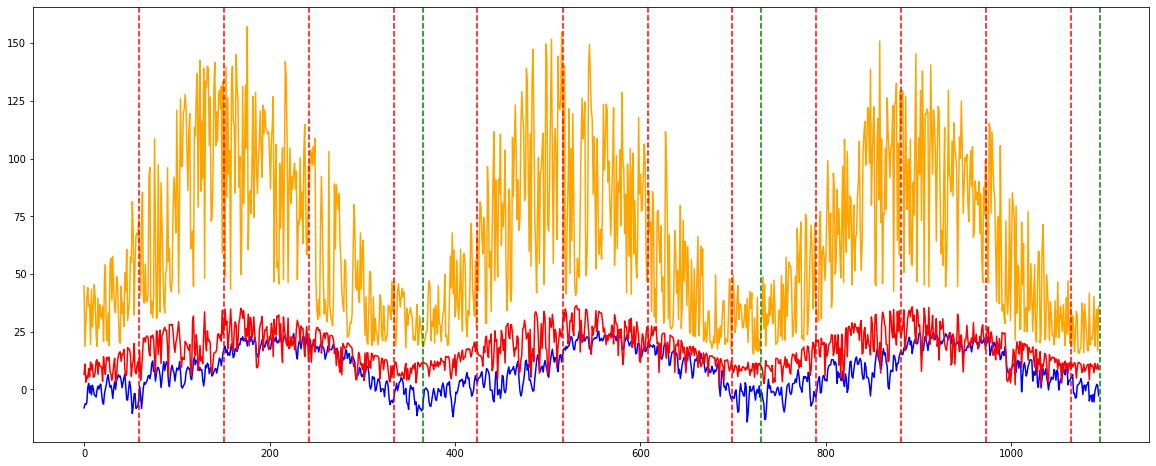

In [7]:
# 계절 나누기

t = train.groupby('Day').mean()
month = [31+28, 31+30+31, 30+31+31, 30+31+30, 31]          # [겨울, 봄, 여름, 가을, 겨울]

plt.figure(figsize=(20,8))
plt.plot(t['T'], color='blue')
plt.plot(t['DHI'], color='orange')
plt.plot(t['TARGET'], color='red')
m=0
for i in range(3):
    for j in range(5):
        m += month[j]
        if j==4:
            plt.axvline(x=m, color='g', linestyle='--')
        else:
            plt.axvline(x=m, color='r', linestyle='--')
plt.show()

# Preprocessing (Train)

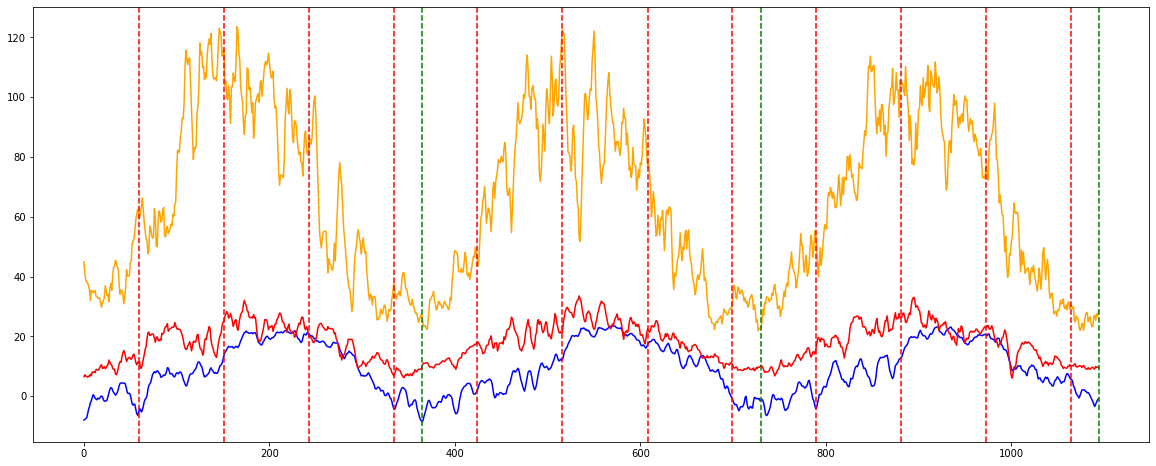

In [8]:
temp = train.copy()

# 30분 단위로 표현

temp['Minute'] = temp['Minute']/60
temp['Time'] = temp['Hour'] + temp['Minute']


# GHI = DHI + DNI

temp['GHI'] = temp['DHI'] + temp['DNI']


# 계절 변수 생성

month = [31+28, 31+30+31, 30+31+31, 30+31+30, 31]          # [겨울, 봄_가을, 여름, 봄_가을, 겨울]

season = []
for i in range(3):
    year = ['Winter']*month[0]*48 + ['Spring_Fall']*month[1]*48 + ['Summer']*month[2]*48 + ['Spring_Fall']*month[3]*48 + ['Winter']*month[4]*48
    season += year
    
temp['Season'] = season


# 계절 판단 기준

df_T = temp.groupby('Day').mean()
df_DHI = temp.groupby('Day').mean()
df_Target = temp.groupby('Day').mean()

for lag in [1,2,3,4,5,6]:
    df_T['T_lag_%s'%lag] = df_T['T'].shift(lag).fillna(method='bfill')
    df_DHI['DHI_lag_%s'%lag] = df_DHI['DHI'].shift(lag).fillna(method='bfill')
    df_Target['Target_lag_%s'%lag] = df_Target['TARGET'].shift(lag).fillna(method='bfill')
    
season = []
for i in range(3):
    year = ['Winter']*month[0] + ['Spring']*month[1] + ['Summer']*month[2] + ['Fall']*month[3] + ['Winter']*month[4]
    season += year
df_T['Season'] = season
df_DHI['Season'] = season
df_Target['Season'] = season

df_T = df_T[['Season', 'T', 'T_lag_1', 'T_lag_2', 'T_lag_3', 'T_lag_4', 'T_lag_5', 'T_lag_6']]
df_DHI = df_DHI[['Season', 'DHI', 'DHI_lag_1', 'DHI_lag_2', 'DHI_lag_3', 'DHI_lag_4', 'DHI_lag_5', 'DHI_lag_6']]
df_Target = df_Target[['Season', 'TARGET', 'Target_lag_1', 'Target_lag_2', 'Target_lag_3', 'Target_lag_4', 'Target_lag_5', 'Target_lag_6']]
df_T['T_mean'] = df_T.mean(axis=1)
df_DHI['DHI_mean'] = df_DHI.mean(axis=1)
df_Target['Target_mean'] = df_Target.mean(axis=1)

df_season = pd.DataFrame({'Season' : df_T['Season'], 'T_mean' : df_T['T_mean'], 
                          'DHI_mean' : df_DHI['DHI_mean'], 'Target_mean' : df_Target['Target_mean']}).reset_index(drop=True)

plt.figure(figsize=(20,8))
plt.plot(df_season['T_mean'], color='blue')
plt.plot(df_season['DHI_mean'], color='orange')
plt.plot(df_season['Target_mean'], color='red')
m=0
for i in range(3):
    for j in range(5):
        m += month[j]
        if j==4:
            plt.axvline(x=m, color='g', linestyle='--')
        else:
            plt.axvline(x=m, color='r', linestyle='--')
plt.show()

In [9]:
df_season.groupby('Season').agg([min,max])        # 기준 : 겨울 ~0  봄가을 0~15  여름 15~

T_mean              DHI_mean             Target_mean           
              min        max        min         max         min        max
Season                                                                    
Fall    -3.083333  20.812500  22.238095  100.336310    6.049196  25.271062
Spring  -5.500000  14.068452  39.991071  123.000000    9.319954  27.902417
Summer  12.232143  23.586310  51.761905  123.541667   17.032536  33.523739
Winter  -8.648810   5.714286  21.877976   62.529762    6.166902  17.618068

In [10]:
# 자기회귀

lags = [1,2,3,4]
cols = ['TARGET', 'DHI', 'DNI', 'GHI', 'WS', 'RH', 'T']
lag_cols = []

for col in cols:
    for lag in lags:
        temp[col + '_lag_%s'%lag] = temp[col].shift(lag*48)                   # 전날의 변수들을 독립변수로 사용
        temp['Target1'] = temp['TARGET']                                      # 예측할값1 => 오늘 발전량
        temp['Target2'] = temp['TARGET'].shift(-48)                           # 예측할값2 => 내일 발전량
        lag_cols.append(col + '_lag_%s'%lag)                                  # 사용할 칼럼 이름 저장


# 계절-시간 별 평균/사분위수

time = temp['Time'].unique()
season = ['Spring_Fall', 'Summer', 'Winter']
dv_t=[]

for s in season :
    tst_season=[]
    tst_mean=[]
    tst_q1=[]
    tst_q2=[]
    tst_q3=[]
    
    for t in time :
        tst = temp.loc[(temp['Season']==s) & (temp['Time']==t)]['TARGET']
        tst_season.append(s)
        tst_mean.append(tst.mean())
        tst_q1.append(tst.quantile(.25))
        tst_q2.append(tst.quantile(.5))
        tst_q3.append(tst.quantile(.75))
        
    dv_t.append(pd.DataFrame({'tst_mean' : tst_mean, 'tst_q1' : tst_q1, 'tst_q2' : tst_q2, 'tst_q3' : tst_q3}))

spring_fall_t = dv_t[0]
summer_t = dv_t[1]
winter_t = dv_t[2]

dv_r=[]

for s in season :
    rst_season=[]
    rst_mean=[]
    rst_q1=[]
    rst_q2=[]
    rst_q3=[]
    
    for t in time :
        rst = temp.loc[(temp['Season']==s) & (temp['Time']==t)]['GHI']
        rst_season.append(s)
        rst_mean.append(rst.mean())
        rst_q1.append(rst.quantile(.25))
        rst_q2.append(rst.quantile(.5))
        rst_q3.append(rst.quantile(.75))
        
    dv_r.append(pd.DataFrame({'rst_mean' : rst_mean, 'rst_q1' : rst_q1, 'rst_q2' : rst_q2, 'rst_q3' : rst_q3}))

spring_fall_r = dv_r[0]
summer_r = dv_r[1]
winter_r = dv_r[2]

month = [31+28, 31+30+31, 30+31+31, 30+31+30, 31]          # [겨울, 봄, 여름, 가을, 겨울]
season_t = [winter_t, spring_fall_t, summer_t, spring_fall_t, winter_t]
season_r = [winter_r, spring_fall_r, summer_r, spring_fall_r, winter_r]
df_dv_t = pd.DataFrame()
df_dv_r = pd.DataFrame()

for i in range(3):
    for s, m in zip(season_t, month):
        for j in range(m):
            df_dv_t = pd.concat([df_dv_t, s])
            
df_dv_t.reset_index(drop=True, inplace=True)
dv_t_cols = list(df_dv_t.columns)
temp = pd.concat([temp, df_dv_t], axis=1)

for i in range(3):
    for s, m in zip(season_r, month):
        for j in range(m):
            df_dv_r = pd.concat([df_dv_r, s])
            
df_dv_r.reset_index(drop=True, inplace=True)
dv_r_cols = list(df_dv_r.columns)
temp = pd.concat([temp, df_dv_r], axis=1)


# 7일간 발전량/일사량 평균

target_4 = temp[['TARGET_lag_1', 'TARGET_lag_2', 'TARGET_lag_3', 'TARGET_lag_4']]
temp['Target_4'] = target_4.mean(axis=1)

GHI_4 = temp[['GHI_lag_1', 'GHI_lag_2', 'GHI_lag_3', 'GHI_lag_4']]
temp['GHI_4'] = GHI_4.mean(axis=1)


df_train = temp[['Target1', 'Target2'] + ['Time'] + lag_cols + dv_t_cols + dv_r_cols + ['Target_4', 'GHI_4']].dropna()
df_train.reset_index(drop=True, inplace=True)
df_train.iloc[:48]

,Target1,Target2,Time,TARGET_lag_1,TARGET_lag_2,TARGET_lag_3,TARGET_lag_4,DHI_lag_1,DHI_lag_2,DHI_lag_3,...,tst_mean,tst_q1,tst_q2,tst_q3,rst_mean,rst_q1,rst_q2,rst_q3,Target_4,GHI_4
0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.00,0.000000,0.00
1,0.000000,0.000000,0.5,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.00,0.000000,0.00
2,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.00,0.000000,0.00
3,0.000000,0.000000,1.5,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.00,0.000000,0.00
4,0.000000,0.000000,2.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.00,0.000000,0.00
5,0.000000,0.000000,2.5,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.00,0.000000,0.00
6,0.000000,0.000000,3.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.00,0.000000,0.00
7,0.000000,0.000000,3.5,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.00,0.000000,0.00
8,0.000000,0.000000,4.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.00,0.000000,0.00
9,0.000000,0.000000,4.5,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.00,0.000000,0.00


In [11]:
df_train.columns

Index(['Target1', 'Target2', 'Time', 'TARGET_lag_1', 'TARGET_lag_2',
       'TARGET_lag_3', 'TARGET_lag_4', 'DHI_lag_1', 'DHI_lag_2', 'DHI_lag_3',
       'DHI_lag_4', 'DNI_lag_1', 'DNI_lag_2', 'DNI_lag_3', 'DNI_lag_4',
       'GHI_lag_1', 'GHI_lag_2', 'GHI_lag_3', 'GHI_lag_4', 'WS_lag_1',
       'WS_lag_2', 'WS_lag_3', 'WS_lag_4', 'RH_lag_1', 'RH_lag_2', 'RH_lag_3',
       'RH_lag_4', 'T_lag_1', 'T_lag_2', 'T_lag_3', 'T_lag_4', 'tst_mean',
       'tst_q1', 'tst_q2', 'tst_q3', 'rst_mean', 'rst_q1', 'rst_q2', 'rst_q3',
       'Target_4', 'GHI_4'],
      dtype='object')

In [12]:
len(df_train.columns)

41

In [13]:
df_train.corr()

,Target1,Target2,Time,TARGET_lag_1,TARGET_lag_2,TARGET_lag_3,TARGET_lag_4,DHI_lag_1,DHI_lag_2,DHI_lag_3,...,tst_mean,tst_q1,tst_q2,tst_q3,rst_mean,rst_q1,rst_q2,rst_q3,Target_4,GHI_4
Target1,1.000000,0.842926,0.003760,0.842907,0.817650,0.806899,0.805247,0.690455,0.703076,0.710208,...,0.880550,0.860270,0.877848,0.876177,0.834559,0.825982,0.833974,0.814885,0.876540,0.800025
Target2,0.842926,1.000000,0.003764,0.817674,0.806986,0.805267,0.805884,0.703101,0.710214,0.714485,...,0.880000,0.859706,0.877389,0.875555,0.834369,0.825591,0.833808,0.814756,0.866660,0.788845
Time,0.003760,0.003764,1.000000,0.003749,0.003752,0.003766,0.003742,0.029861,0.029858,0.029850,...,0.004229,-0.029021,0.002033,0.021101,-0.010084,-0.063280,-0.026946,0.013114,0.004020,-0.009324
TARGET_lag_1,0.842907,0.817674,0.003749,1.000000,0.842860,0.817559,0.806851,0.666691,0.690405,0.703064,...,0.880961,0.860540,0.878361,0.876681,0.834599,0.826113,0.834041,0.814927,0.928653,0.858708
TARGET_lag_2,0.817650,0.806986,0.003752,0.842860,1.000000,0.842697,0.817509,0.689043,0.666657,0.690390,...,0.881734,0.861255,0.879252,0.877528,0.834720,0.826523,0.834186,0.814965,0.938240,0.870157
TARGET_lag_3,0.806899,0.805267,0.003766,0.817559,0.842697,1.000000,0.842624,0.707062,0.689019,0.666581,...,0.882386,0.861884,0.879859,0.878257,0.835100,0.827142,0.834594,0.815259,0.938191,0.870071
TARGET_lag_4,0.805247,0.805884,0.003742,0.806851,0.817509,0.842624,1.000000,0.709528,0.707039,0.689007,...,0.882993,0.862410,0.880467,0.878965,0.835240,0.827469,0.834724,0.815368,0.928574,0.858684
DHI_lag_1,0.690455,0.703101,0.029861,0.666691,0.689043,0.707062,0.709528,1.000000,0.703177,0.674165,...,0.767409,0.725036,0.767385,0.775432,0.717847,0.679681,0.712347,0.714226,0.742522,0.638786
DHI_lag_2,0.703076,0.710214,0.029858,0.690405,0.666657,0.689019,0.707039,0.703177,1.000000,0.703151,...,0.767848,0.725448,0.767848,0.775925,0.718040,0.679977,0.712538,0.714399,0.737379,0.632035
DHI_lag_3,0.710208,0.714485,0.029850,0.703064,0.690390,0.666581,0.689007,0.674165,0.703151,1.000000,...,0.768266,0.725843,0.768489,0.776334,0.718055,0.680050,0.712540,0.714428,0.736287,0.630762


# Preprocessing (Test)

In [14]:
df_test = []

for i in range(81):
    file_path = './data/test/' + str(i) + '.csv'
    temp = pd.read_csv(file_path)
    
    
    # 30분 단위로 표현

    temp['Minute'] = temp['Minute']/60
    temp['Time'] = temp['Hour'] + temp['Minute']
    
    
    # GHI = DHI + DNI

    temp['GHI'] = temp['DHI'] + temp['DNI']

    
    # 계절 구분 기준

    T_mean = temp['T'].mean()


    # 자기회귀

    df_append = temp.iloc[:48, :]
    temp = pd.concat([temp, df_append]).reset_index()

    lags = [1,2,3,4]
    cols = ['TARGET', 'DHI', 'DNI', 'GHI', 'WS', 'RH', 'T']
    lag_cols = []

    for col in cols:
        for lag in lags:
            temp[col + '_lag_%s'%lag] = temp[col].shift(lag*48)          # 전날의 변수들을 독립변수로 사용
            lag_cols.append(col + '_lag_%s'%lag)

            
   # 7일간 발전량/일사량 평균

    target_4 = temp[['TARGET_lag_1', 'TARGET_lag_2', 'TARGET_lag_3', 'TARGET_lag_4']]
    temp['Target_4'] = target_4.mean(axis=1)

    GHI_4 = temp[['GHI_lag_1', 'GHI_lag_2', 'GHI_lag_3', 'GHI_lag_4']]
    temp['GHI_4'] = GHI_4.mean(axis=1)
    
    
    # day7만 사용
    
    temp = temp.iloc[-48:, :]
    temp.reset_index(drop=True, inplace=True)
    
    
    # 계절-시간 별 평균/사분위수

    if T_mean < 0:
        temp = pd.concat([temp, winter_t, winter_r], axis=1)

    elif (T_mean >= 0) & (T_mean < 15):
        temp = pd.concat([temp, spring_fall_t, spring_fall_r], axis=1)

    elif T_mean >= 15:
        temp = pd.concat([temp, summer_t, summer_r], axis=1)

    dv_cols = list(winter_t.columns) + list(winter_r.columns)


    temp = temp[['Time'] + lag_cols + dv_cols + ['Target_4', 'GHI_4']].dropna()
    temp.reset_index(drop=True, inplace=True)
    df_test.append(temp)

X_test = pd.concat(df_test)
X_test.shape

(3888, 39)

In [15]:
X_test.columns

Index(['Time', 'TARGET_lag_1', 'TARGET_lag_2', 'TARGET_lag_3', 'TARGET_lag_4',
       'DHI_lag_1', 'DHI_lag_2', 'DHI_lag_3', 'DHI_lag_4', 'DNI_lag_1',
       'DNI_lag_2', 'DNI_lag_3', 'DNI_lag_4', 'GHI_lag_1', 'GHI_lag_2',
       'GHI_lag_3', 'GHI_lag_4', 'WS_lag_1', 'WS_lag_2', 'WS_lag_3',
       'WS_lag_4', 'RH_lag_1', 'RH_lag_2', 'RH_lag_3', 'RH_lag_4', 'T_lag_1',
       'T_lag_2', 'T_lag_3', 'T_lag_4', 'tst_mean', 'tst_q1', 'tst_q2',
       'tst_q3', 'rst_mean', 'rst_q1', 'rst_q2', 'rst_q3', 'Target_4',
       'GHI_4'],
      dtype='object')

In [16]:
len(X_test.columns)

39

In [17]:
# train 지정

X_train = df_train.iloc[:, 2:]
y_train_1 = df_train.iloc[:, 0]
y_train_2 = df_train.iloc[:, 1]

In [18]:
from xgboost import XGBRegressor
from functools import partial

class XGBQuantile(XGBRegressor):
    def __init__(self,quant_alpha=0.95,quant_delta = 1.0,quant_thres=1.0,quant_var =1.0,base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
                n_jobs=1, nthread=None, objective='reg:linear', random_state=0,reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,silent=True, subsample=1):
        self.quant_alpha = quant_alpha
        self.quant_delta = quant_delta
        self.quant_thres = quant_thres
        self.quant_var = quant_var
    
        super().__init__(base_score=base_score, booster=booster, colsample_bylevel=colsample_bylevel,
           colsample_bytree=colsample_bytree, gamma=gamma, learning_rate=learning_rate, max_delta_step=max_delta_step,
           max_depth=max_depth, min_child_weight=min_child_weight, missing=missing, n_estimators=n_estimators,
           n_jobs= n_jobs, nthread=nthread, objective=objective, random_state=random_state,
           reg_alpha=reg_alpha, reg_lambda=reg_lambda, scale_pos_weight=scale_pos_weight, seed=seed,
           silent=silent, subsample=subsample)
    
        self.test = None
  
    def fit(self, X, y):
        super().set_params(objective=partial(XGBQuantile.quantile_loss,alpha = self.quant_alpha,delta = self.quant_delta,threshold = self.quant_thres,var = self.quant_var) )
        super().fit(X,y)
        return self
  
    def predict(self,X):
        return super().predict(X)
  
    def score(self, X, y):
        y_pred = super().predict(X)
        score = XGBQuantile.quantile_score(y, y_pred, self.quant_alpha)
        score = 1./score
        return score
      
# staticmethod
    def quantile_loss(y_true,y_pred,alpha,delta,threshold,var):
        x = y_true - y_pred
        grad = (x<(alpha-1.0)*delta)*(1.0-alpha)-  ((x>=(alpha-1.0)*delta)& (x<alpha*delta) )*x/delta-alpha*(x>alpha*delta)
        hess = ((x>=(alpha-1.0)*delta)& (x<alpha*delta) )/delta 
 
        grad = (np.abs(x)<threshold )*grad - (np.abs(x)>=threshold )*(2*np.random.randint(2, size=len(y_true)) -1.0)*var
        hess = (np.abs(x)<threshold )*hess + (np.abs(x)>=threshold )
        return grad, hess
    
# staticmethod
    def original_quantile_loss(y_true,y_pred,alpha,delta):
        x = y_true - y_pred
        grad = (x<(alpha-1.0)*delta)*(1.0-alpha)-((x>=(alpha-1.0)*delta)& (x<alpha*delta) )*x/delta-alpha*(x>alpha*delta)
        hess = ((x>=(alpha-1.0)*delta)& (x<alpha*delta) )/delta 
        return grad,hess

# staticmethod
    def quantile_score(y_true, y_pred, alpha):
        score = XGBQuantile.quantile_cost(x=y_true-y_pred,alpha=alpha)
        score = np.sum(score)
        return score
    
# staticmethod
    def quantile_cost(x, alpha):
        return (alpha-1.0)*x*(x<0)+alpha*x*(x>=0)
    
# staticmethod
    def get_split_gain(gradient,hessian,l=1):
        split_gain = list()
        for i in range(gradient.shape[0]):
            split_gain.append(np.sum(gradient[:i])/(np.sum(hessian[:i])+l)+np.sum(gradient[i:])/(np.sum(hessian[i:])+l)-np.sum(gradient)/(np.sum(hessian)+l) )
    
        return np.array(split_gain)


In [28]:
from sklearn.model_selection import cross_val_score

In [29]:
np.mean(cross_val_score(XGBRegressor(), X_train, y_train_1))

0.7776959127093572

In [30]:
np.mean(cross_val_score(XGBRegressor(), X_train, y_train_2))

0.7682127576069322

In [19]:
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]    # alpha 값

def XGB(X_train, Y_train, X_test):

    XGB_models=[]
    XGB_actual_pred = pd.DataFrame()

    for q in quantiles:
        
        print('\n',q)
        
        model = XGBQuantile(random_state=100)
        model.set_params(quant_alpha=q)
        
        model.fit(X_train, Y_train)
        XGB_models.append(model)
        
        pred = pd.Series(model.predict(X_test).round(2))
        XGB_actual_pred = pd.concat([XGB_actual_pred, pred], axis=1)
    
    XGB_actual_pred.columns=quantiles
    
    return XGB_models, XGB_actual_pred

In [20]:
# Target1
models_1, results_1 = XGB(X_train, y_train_1, X_test)
results_1.sort_index()[:48]


 0.1
[00:29:05] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { quant_alpha, quant_delta, quant_thres, quant_var, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



 0.2
[00:29:16] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { quant_alpha, quant_delta, quant_thres, quant_var, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



 0.3
[00:29:25] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: 

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,-0.00,0.00,0.00,0.00,0.00,-460.929993,-345.570007,-230.169998,-114.830002
1,-0.00,0.00,0.00,0.00,0.00,-460.929993,-345.570007,-230.160004,-114.830002
2,-0.00,0.00,0.00,0.00,0.00,-460.929993,-345.579987,-230.169998,-114.820000
3,-0.00,0.00,0.00,0.00,0.00,-460.929993,-345.570007,-230.169998,-114.809998
4,-0.00,0.00,0.00,0.00,0.00,-460.929993,-345.570007,-230.169998,-114.820000
5,-0.00,0.00,0.00,0.00,0.00,-460.929993,-345.570007,-230.179993,-114.820000
6,-0.00,0.00,0.00,0.00,0.00,-460.929993,-345.570007,-230.169998,-114.809998
7,-0.00,0.00,0.00,0.00,0.00,-460.929993,-345.570007,-230.179993,-114.809998
8,-0.00,0.00,0.00,0.00,0.00,-460.929993,-345.559998,-230.169998,-114.800003
9,-0.00,0.00,0.00,0.00,0.00,-460.940002,-345.559998,-230.179993,-114.800003


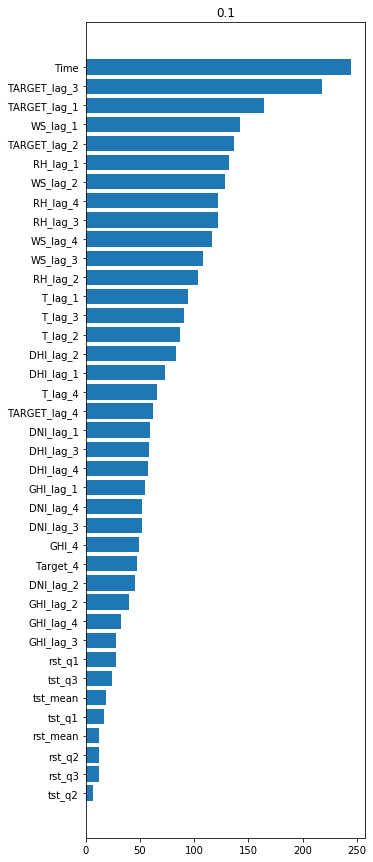

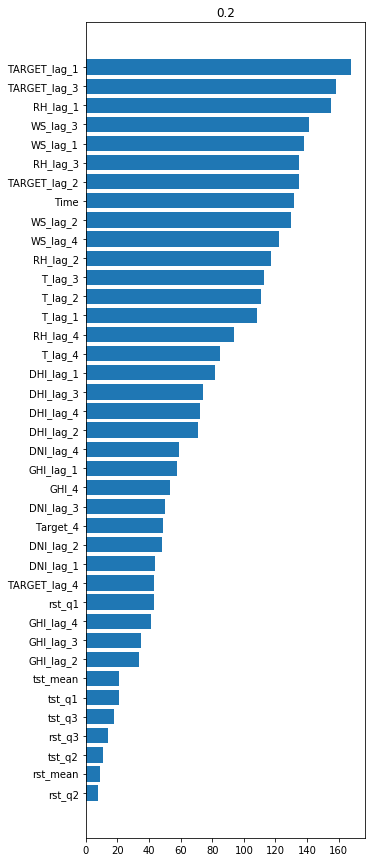

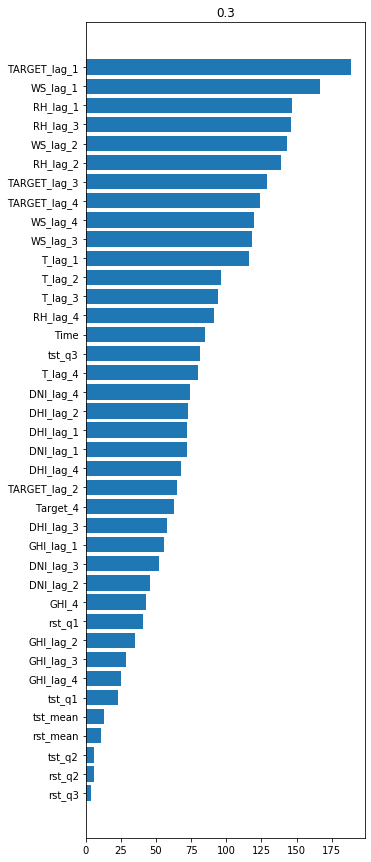

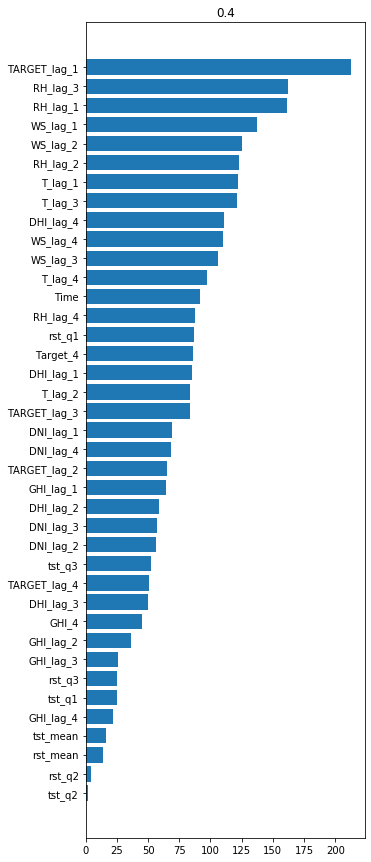

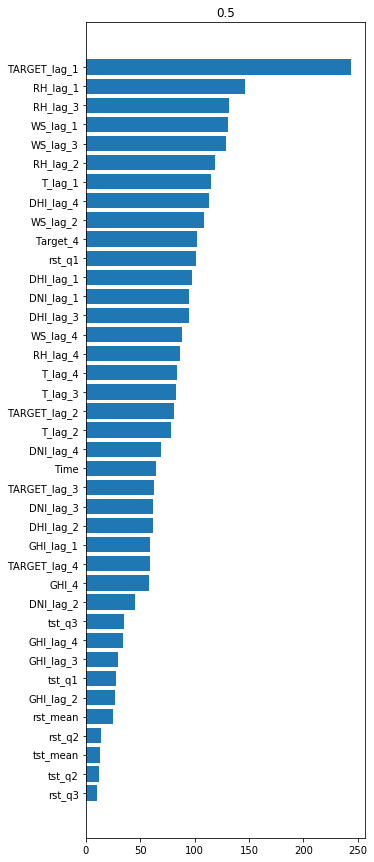

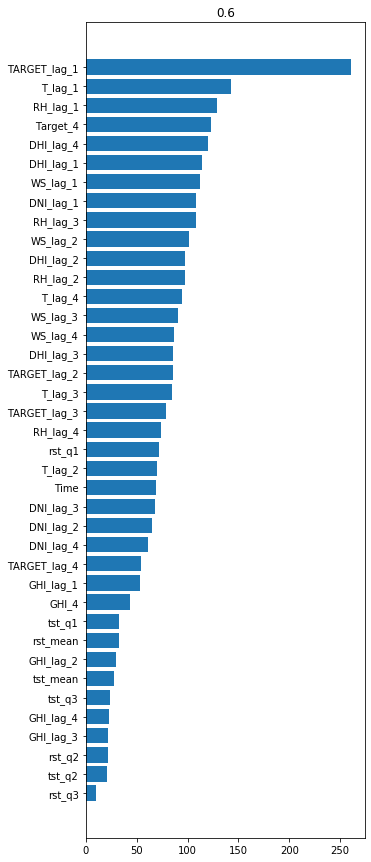

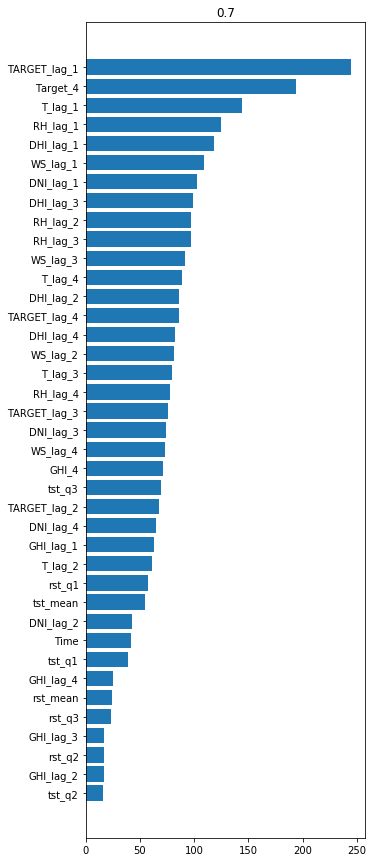

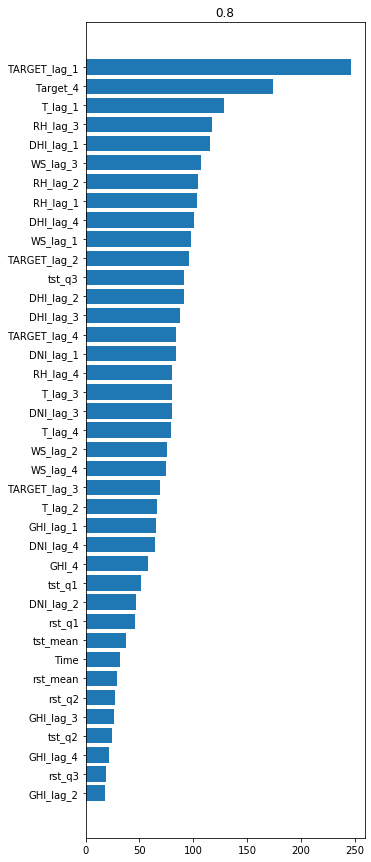

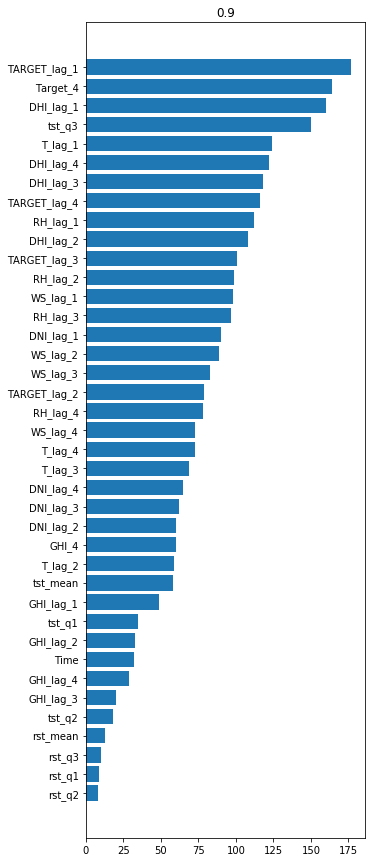

In [199]:
for i in range(9):
    fi = pd.Series(models_1[i].feature_importances_, index=X_train.columns).sort_values(ascending=True)
    
    plt.figure(figsize=(5,15))
    plt.title('0.%s'%(i+1))
    plt.barh(fi.index, fi)
    plt.show()

In [200]:
# Target2
models_2, results_2 = train_data(X_train, y_train_2, X_test)
results_2.sort_index()[:48]


 0.1

 0.2

 0.3

 0.4

 0.5

 0.6

 0.7

 0.8

 0.9


,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


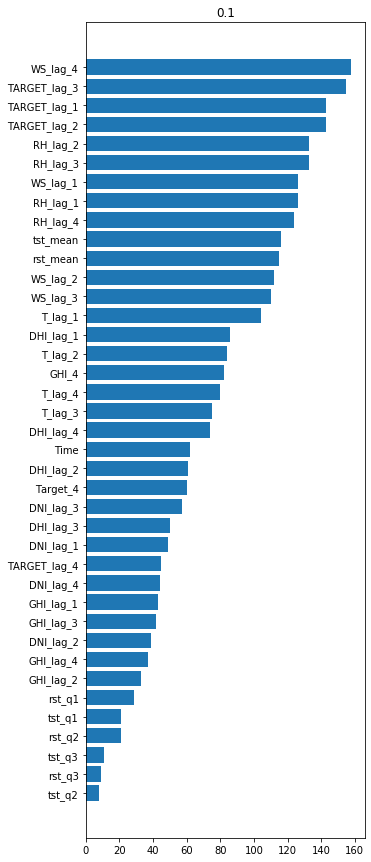

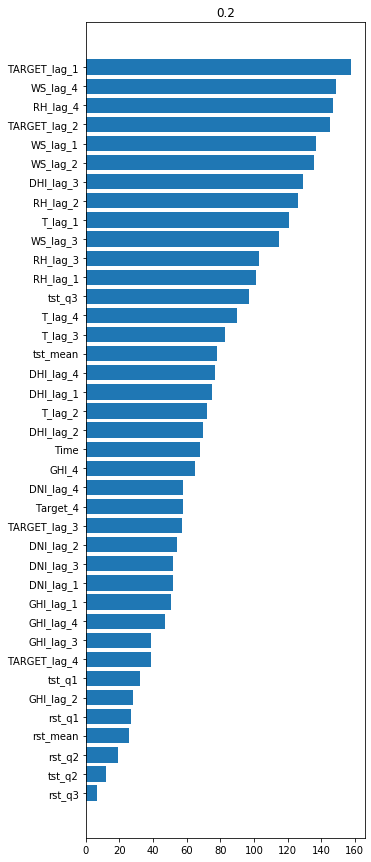

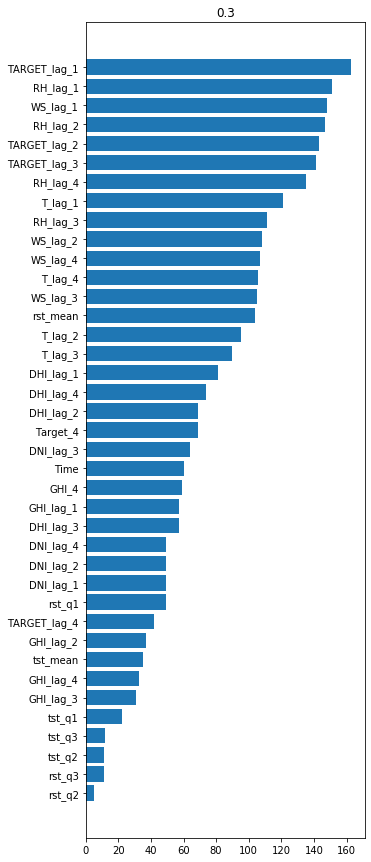

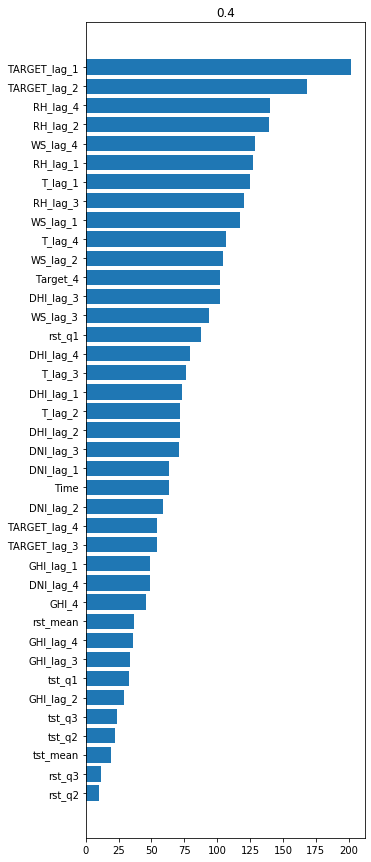

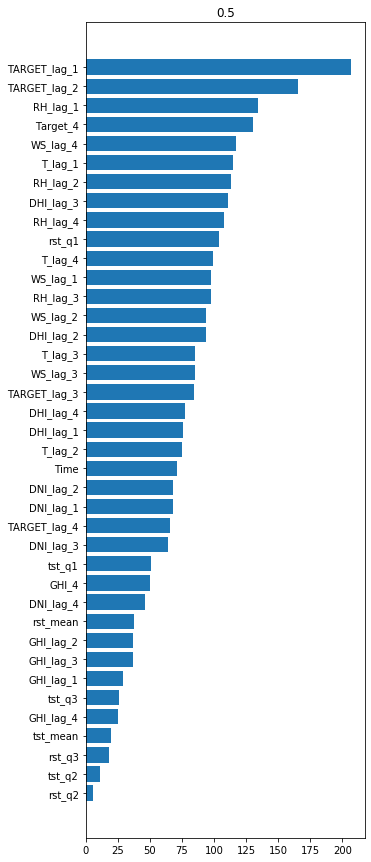

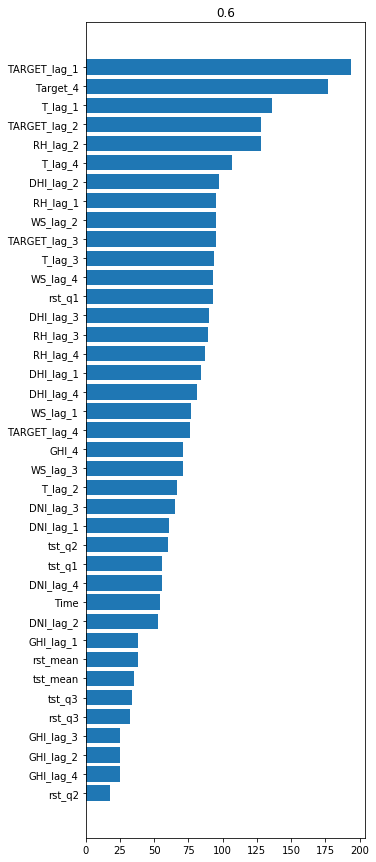

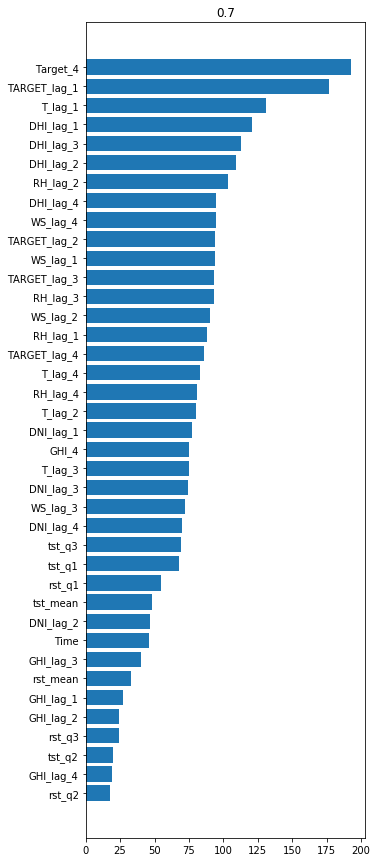

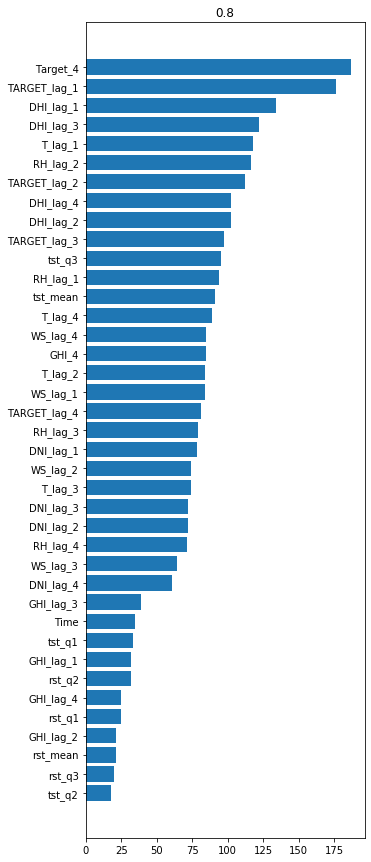

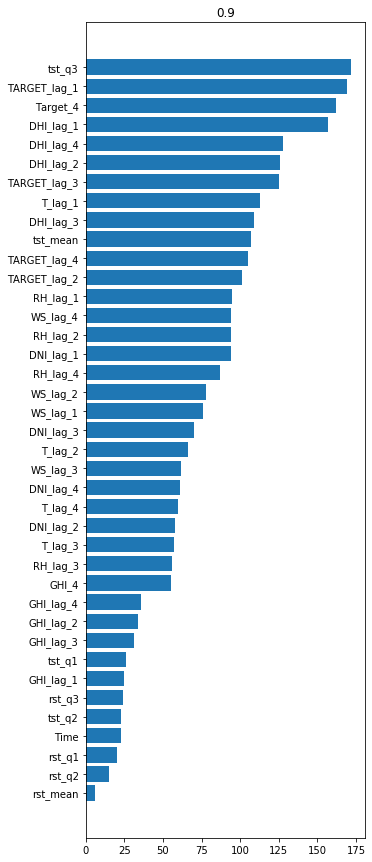

In [201]:
for i in range(9):
    fi = pd.Series(models_2[i].feature_importances_, index=X_train.columns).sort_values(ascending=True)
    
    plt.figure(figsize=(5,15))
    plt.title('0.%s'%(i+1))
    plt.barh(fi.index, fi)
    plt.show()

In [202]:
results_1.sort_index().iloc[:48]

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [203]:
results_2.sort_index()

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
3883,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3884,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3885,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3886,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [204]:
print(results_1.shape, results_2.shape)

(3888, 9) (3888, 9)


In [205]:
submission.loc[submission.id.str.contains("Day7"), "q_0.1":] = results_1.sort_index().values
submission.loc[submission.id.str.contains("Day8"), "q_0.1":] = results_2.sort_index().values
submission

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0,0.csv_Day7_0h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.csv_Day7_0h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.csv_Day7_1h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.csv_Day7_1h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.csv_Day7_2h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
7771,80.csv_Day8_21h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7772,80.csv_Day8_22h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7773,80.csv_Day8_22h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7774,80.csv_Day8_23h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [206]:
submission.iloc[:48]

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0,0.csv_Day7_0h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.csv_Day7_0h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.csv_Day7_1h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.csv_Day7_1h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.csv_Day7_2h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.csv_Day7_2h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.csv_Day7_3h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.csv_Day7_3h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,0.csv_Day7_4h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.csv_Day7_4h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [207]:
submission.iloc[48:96]

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
48,0.csv_Day8_0h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
49,0.csv_Day8_0h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50,0.csv_Day8_1h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
51,0.csv_Day8_1h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
52,0.csv_Day8_2h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
53,0.csv_Day8_2h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
54,0.csv_Day8_3h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
55,0.csv_Day8_3h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
56,0.csv_Day8_4h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
57,0.csv_Day8_4h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [176]:
submission.to_csv('./data/submission_21.csv', index=False)